## 1. Import Thư Viện

In [32]:
import os
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

warnings.filterwarnings('ignore')

# Thiết lập seed để tái tạo kết quả
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Đã import thư viện thành công')

Đã import thư viện thành công


## 2. Cấu Hình Đường Dẫn và Tham Số

In [33]:
# Đường dẫn dataset
BASE_DIR = Path(r'd:\PDDD\Dataset.v2')
OUTPUT_DIR = Path(r'd:\PDDD\output')

# CSV metadata
HS_CSV = BASE_DIR / 'HS.csv'
LS_CSV = BASE_DIR / 'LS.csv'

# Thư mục WAV
HS_WAV_DIR = BASE_DIR / 'HS' / 'HS'
LS_WAV_DIR = BASE_DIR / 'LS' / 'LS'

# Thư mục output
MEL_IMAGES_DIR = OUTPUT_DIR / 'mel_images'
TRAIN_DIR = OUTPUT_DIR / 'train'
VAL_DIR = OUTPUT_DIR / 'val'
MODELS_DIR = OUTPUT_DIR / 'models'

# Tạo thư mục output
for dir_path in [MEL_IMAGES_DIR, TRAIN_DIR, VAL_DIR, MODELS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Tham số xử lý âm thanh
TAN_SO_MAU = 4000
DO_DAI_GIAY = 5
SO_MEL = 128
KICH_THUOC_ANH = (128, 128)

# Tham số training
KICH_THUOC_LO = 16
SO_EPOCH = 50
TY_LE_HOC = 1e-4

print('Cấu hình hoàn tất')
print(f'Dataset path: {BASE_DIR}')
print(f'Output path: {OUTPUT_DIR}')
print(f'Tần số mẫu: {TAN_SO_MAU} Hz, Độ dài: {DO_DAI_GIAY}s, Số Mel bands: {SO_MEL}')

Cấu hình hoàn tất
Dataset path: d:\PDDD\Dataset.v2
Output path: d:\PDDD\output
Tần số mẫu: 4000 Hz, Độ dài: 5s, Số Mel bands: 128


## 3. Khám Phá Dữ Liệu (EDA)

In [34]:
# Đọc metadata
df_hs = pd.read_csv(HS_CSV)
df_ls = pd.read_csv(LS_CSV)

# Đọc HS.csv và LS.csv
du_lieu_hs = pd.read_csv(HS_CSV)
du_lieu_ls = pd.read_csv(LS_CSV)

print('HS.csv - 5 dòng đầu:')
display(du_lieu_hs.head())
print('\nThông tin tổng quan HS.csv:')
du_lieu_hs.info()

print('\nLS.csv - 5 dòng đầu:')
display(du_lieu_ls.head())
print('\nThông tin tổng quan LS.csv:')
du_lieu_ls.info()


HS.csv - 5 dòng đầu:


,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Normal,RC,F_N_RC
1,F,Normal,LC,F_N_LC
2,M,Normal,RUSB,M_N_RUSB
3,F,Normal,LUSB,F_N_LUSB
4,F,Normal,LLSB,F_N_LLSB



Thông tin tổng quan HS.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gender            50 non-null     object
 1   Heart Sound Type  50 non-null     object
 2   Location          50 non-null     object
 3   Heart Sound ID    50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB

LS.csv - 5 dòng đầu:


,Gender,Lung Sound Type,Location,Lung Sound ID
0,M,Normal,RUA,M_N_RUA
1,F,Normal,LUA,F_N_LUA
2,F,Normal,RMA,F_N_RMA
3,F,Normal,LMA,F_N_LMA
4,M,Normal,RLA,M_N_RLA



Thông tin tổng quan LS.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           50 non-null     object
 1   Lung Sound Type  50 non-null     object
 2   Location         50 non-null     object
 3   Lung Sound ID    50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [35]:
# Thống kê giới tính
print('Giới tính HS:')
display(du_lieu_hs['Gender'].value_counts())

print('Giới tính LS:')
display(du_lieu_ls['Gender'].value_counts())


Giới tính HS:


Gender
F    26
M    24
Name: count, dtype: int64

Giới tính LS:


Gender
M    30
F    20
Name: count, dtype: int64

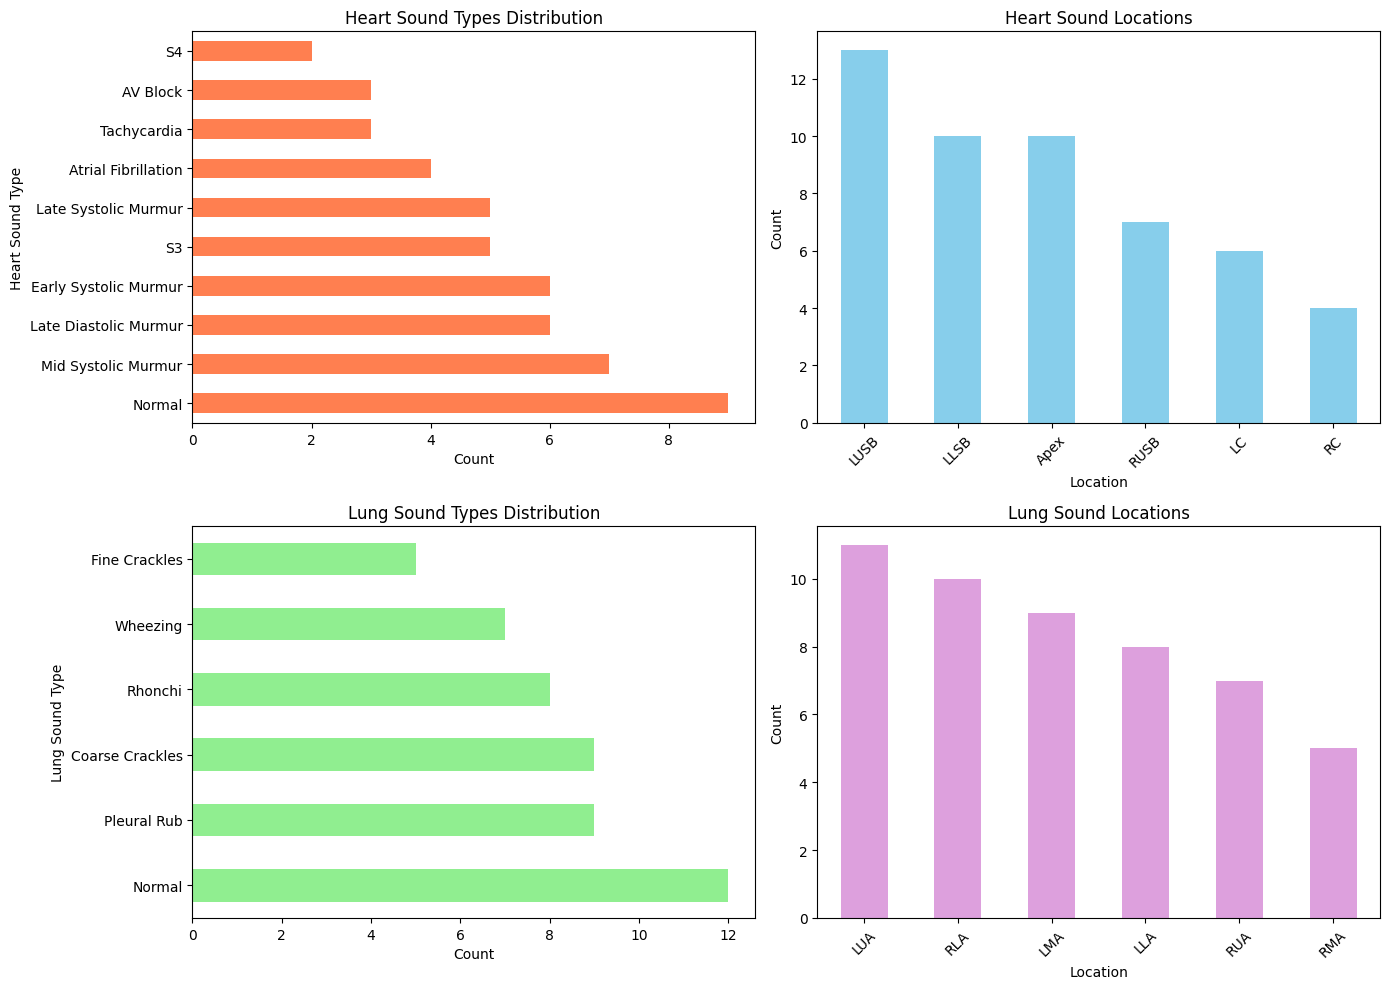

In [36]:
# Visualize phân bố dữ liệu
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# HS - Loại bệnh
df_hs['Heart Sound Type'].value_counts().plot(kind='barh', ax=axes[0, 0], color='coral')
axes[0, 0].set_title('Heart Sound Types Distribution')
axes[0, 0].set_xlabel('Count')

# HS - Vị trí
df_hs['Location'].value_counts().plot(kind='bar', ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Heart Sound Locations')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# LS - Loại bệnh
df_ls['Lung Sound Type'].value_counts().plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Lung Sound Types Distribution')
axes[1, 0].set_xlabel('Count')

# LS - Vị trí
df_ls['Location'].value_counts().plot(kind='bar', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('Lung Sound Locations')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [37]:
# Kiểm tra file WAV
ds_wav_hs = sorted(list(HS_WAV_DIR.glob('*.wav')))
ds_wav_ls = sorted(list(LS_WAV_DIR.glob('*.wav')))

print(f'Số file WAV Heart Sound: {len(ds_wav_hs)}')
print(f'Số file WAV Lung Sound: {len(ds_wav_ls)}')
print(f'Tổng: {len(ds_wav_hs) + len(ds_wav_ls)} files')

if len(ds_wav_hs) == 0 or len(ds_wav_ls) == 0:
    raise FileNotFoundError('Không tìm thấy file WAV. Kiểm tra lại đường dẫn!')

Số file WAV Heart Sound: 50
Số file WAV Lung Sound: 50
Tổng: 100 files


In [38]:
# Thống kê bệnh & vị trí
print('Bảng chéo HS (bệnh - vị trí):')
bang_cheo_hs = pd.crosstab(du_lieu_hs['Heart Sound Type'], du_lieu_hs['Location'])
display(bang_cheo_hs)

print('\nBảng chéo LS (bệnh - vị trí):')
bang_cheo_ls = pd.crosstab(du_lieu_ls['Lung Sound Type'], du_lieu_ls['Location'])
display(bang_cheo_ls)


Bảng chéo HS (bệnh - vị trí):


Location,Apex,LC,LLSB,LUSB,RC,RUSB
Heart Sound Type,,,,,,
AV Block,1,0,1,0,1,0
Atrial Fibrillation,1,1,0,1,0,1
Early Systolic Murmur,1,0,1,2,0,2
Late Diastolic Murmur,1,1,2,2,0,0
Late Systolic Murmur,1,0,1,2,0,1
Mid Systolic Murmur,2,0,1,2,1,1
Normal,1,2,2,1,1,2
S3,1,1,2,1,0,0
S4,0,0,0,1,1,0



Bảng chéo LS (bệnh - vị trí):


Location,LLA,LMA,LUA,RLA,RMA,RUA
Lung Sound Type,,,,,,
Coarse Crackles,2,2,2,2,1,0
Fine Crackles,0,0,2,2,0,1
Normal,2,2,2,2,2,2
Pleural Rub,2,2,2,1,1,1
Rhonchi,1,2,2,2,0,1
Wheezing,1,1,1,1,1,2


## 4. Visualize Âm Thanh Mẫu

In [39]:
# Chọn file mẫu
mau_hs = ds_wav_hs[0]
mau_ls = ds_wav_ls[0]

print(f'File mẫu Heart Sound: {mau_hs.name}')
print(f'File mẫu Lung Sound: {mau_ls.name}')

File mẫu Heart Sound: F_AF_A.wav
File mẫu Lung Sound: F_CC_LLA.wav


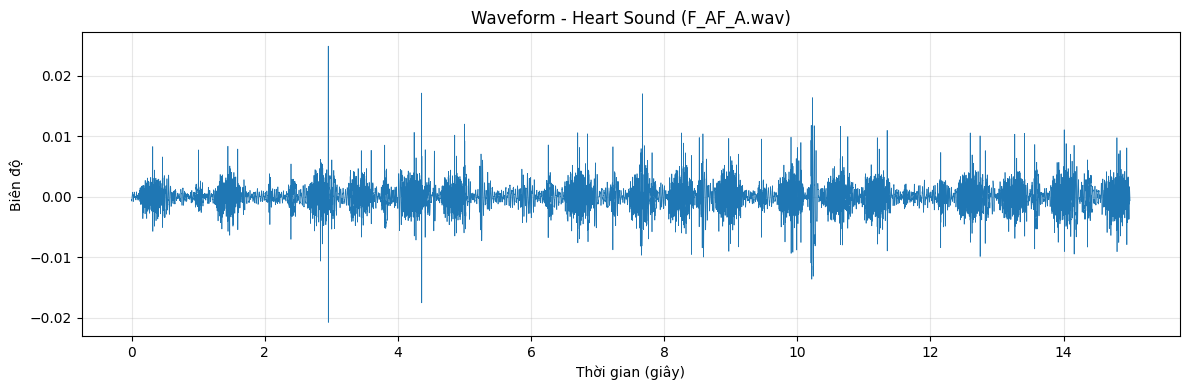

Tần số mẫu: 4000 Hz, Độ dài: 15.00s, Số mẫu: 60000


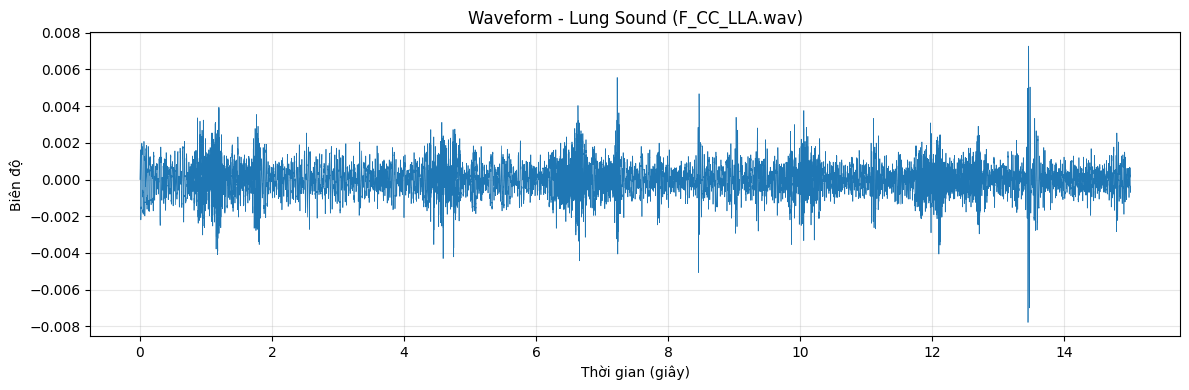

Tần số mẫu: 4000 Hz, Độ dài: 15.00s, Số mẫu: 60000


In [40]:
# Visualize waveform
def ve_dang_song(duong_dan_wav, tieu_de):
    y, sr = librosa.load(duong_dan_wav, sr=None)
    do_dai = len(y) / sr
    thoi_gian = np.linspace(0, do_dai, len(y))
    
    plt.figure(figsize=(12, 4))
    plt.plot(thoi_gian, y, linewidth=0.5)
    plt.title(tieu_de)
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Biên độ')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f'Tần số mẫu: {sr} Hz, Độ dài: {do_dai:.2f}s, Số mẫu: {len(y)}')

ve_dang_song(mau_hs, f'Waveform - Heart Sound ({mau_hs.name})')
ve_dang_song(mau_ls, f'Waveform - Lung Sound ({mau_ls.name})')

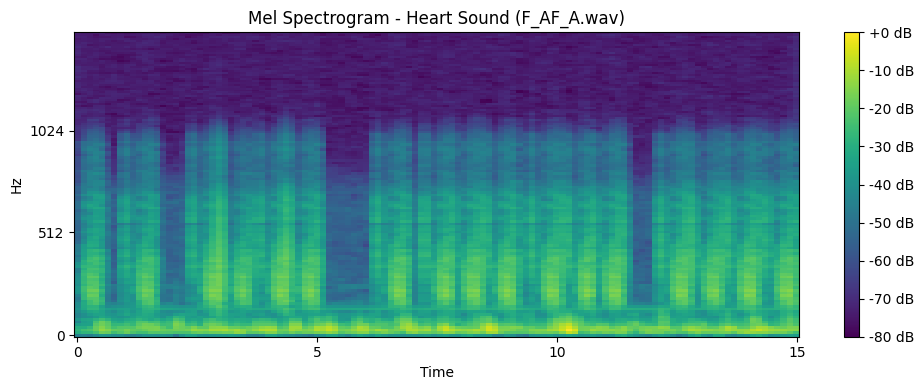

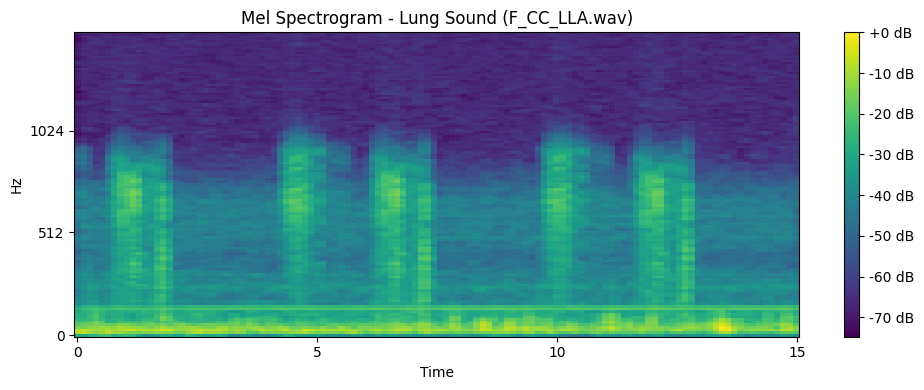

In [41]:
# Visualize Mel Spectrogram
def ve_mel_spectrogram(duong_dan_wav, tieu_de, so_mel=128):
    y, sr = librosa.load(duong_dan_wav, sr=TAN_SO_MAU)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=so_mel)
    S_db = librosa.power_to_db(S, ref=np.max)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(tieu_de)
    plt.tight_layout()
    plt.show()

ve_mel_spectrogram(mau_hs, f'Mel Spectrogram - Heart Sound ({mau_hs.name})')
ve_mel_spectrogram(mau_ls, f'Mel Spectrogram - Lung Sound ({mau_ls.name})')

## 5. Tiền Xử Lý
## KT Lại

In [42]:
# Chuyển WAV sang Mel Spectrogram
def chuyen_wav_sang_mel(duong_dan_wav, tan_so_mau=TAN_SO_MAU, do_dai_giay=DO_DAI_GIAY, so_mel=SO_MEL):
   
    # Load audio
    y, sr = librosa.load(duong_dan_wav, sr=tan_so_mau)
    
    # Padding hoặc crop về độ dài chuẩn
    do_dai_muc_tieu = tan_so_mau * do_dai_giay
    if len(y) < do_dai_muc_tieu:
        y = np.pad(y, (0, do_dai_muc_tieu - len(y)), mode='constant')
    else:
        y = y[:do_dai_muc_tieu]
    
    # Extract Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=so_mel)
    S_db = librosa.power_to_db(S, ref=np.max)
    
    return S_db

# Test hàm
mel_test = chuyen_wav_sang_mel(mau_hs)
print(f'Kích thước mel spectrogram: {mel_test.shape}')
print(f'Khoảng giá trị: [{mel_test.min():.2f}, {mel_test.max():.2f}] dB')

Kích thước mel spectrogram: (128, 40)
Khoảng giá trị: [-70.01, 0.00] dB


In [43]:
def luu_mel_thanh_anh(mel_db, duong_dan_luu, kich_thuoc_anh=KICH_THUOC_ANH):
    """
    Lưu Mel Spectrogram thành ảnh PNG
    """
    plt.figure(figsize=(kich_thuoc_anh[0]/100, kich_thuoc_anh[1]/100), dpi=100)
    plt.axis('off')
    plt.imshow(mel_db, aspect='auto', origin='lower', cmap='viridis')
    plt.savefig(duong_dan_luu, bbox_inches='tight', pad_inches=0)
    plt.close()

# Test hàm
dau_ra_test = OUTPUT_DIR / 'test_mel.png'
luu_mel_thanh_anh(mel_test, dau_ra_test)
print(f'Đã lưu ảnh test: {dau_ra_test}')

Đã lưu ảnh test: d:\PDDD\output\test_mel.png


## 6. Tạo Dataset Mel Images

In [44]:
# Tạo thư mục cho từng class
(MEL_IMAGES_DIR / 'HS').mkdir(exist_ok=True)
(MEL_IMAGES_DIR / 'LS').mkdir(exist_ok=True)

print('Đang xử lý Heart Sound files...')
so_loi = 0
for file_wav in ds_wav_hs:
    try:
        mel = chuyen_wav_sang_mel(file_wav)
        duong_dan_luu = MEL_IMAGES_DIR / 'HS' / f'{file_wav.stem}.png'
        luu_mel_thanh_anh(mel, duong_dan_luu)
    except Exception as e:
        print(f'Lỗi xử lý {file_wav.name}: {e}')
        so_loi += 1

print(f'Hoàn tất Heart Sound: {len(ds_wav_hs) - so_loi}/{len(ds_wav_hs)} files')

print('\nĐang xử lý Lung Sound files...')
for file_wav in ds_wav_ls:
    try:
        mel = chuyen_wav_sang_mel(file_wav)
        duong_dan_luu = MEL_IMAGES_DIR / 'LS' / f'{file_wav.stem}.png'
        luu_mel_thanh_anh(mel, duong_dan_luu)
    except Exception as e:
        print(f'Lỗi xử lý {file_wav.name}: {e}')
        so_loi += 1

print(f'Hoàn tất Lung Sound: {len(ds_wav_ls) - so_loi}/{len(ds_wav_ls)} files')
print(f'\nTổng số lỗi: {so_loi}')

Đang xử lý Heart Sound files...
Hoàn tất Heart Sound: 50/50 files

Đang xử lý Lung Sound files...
Hoàn tất Lung Sound: 50/50 files

Tổng số lỗi: 0


In [45]:
# Kiểm tra số lượng ảnh đã tạo
anh_hs = list((MEL_IMAGES_DIR / 'HS').glob('*.png'))
anh_ls = list((MEL_IMAGES_DIR / 'LS').glob('*.png'))

print(f'Số ảnh Heart Sound: {len(anh_hs)}')
print(f'Số ảnh Lung Sound: {len(anh_ls)}')
print(f'Tổng: {len(anh_hs) + len(anh_ls)} ảnh')

Số ảnh Heart Sound: 50
Số ảnh Lung Sound: 50
Tổng: 100 ảnh


## 7. Chia Train/Validation và Tạo Cấu Trúc Thư Mục

In [46]:
# Load danh sách file và nhãn
tat_ca_anh = []
tat_ca_nhan = []

for duong_dan_anh in anh_hs:
    tat_ca_anh.append(str(duong_dan_anh))
    tat_ca_nhan.append(0)  # HS = 0

for duong_dan_anh in anh_ls:
    tat_ca_anh.append(str(duong_dan_anh))
    tat_ca_nhan.append(1)  # LS = 1

tat_ca_anh = np.array(tat_ca_anh)
tat_ca_nhan = np.array(tat_ca_nhan)

print(f'Tổng số ảnh: {len(tat_ca_anh)}')
print(f'Phân bố nhãn: HS={np.sum(tat_ca_nhan==0)}, LS={np.sum(tat_ca_nhan==1)}')

Tổng số ảnh: 100
Phân bố nhãn: HS=50, LS=50


In [47]:
# Chia train/validation với stratify
X_train, X_val, y_train, y_val = train_test_split(
    tat_ca_anh, tat_ca_nhan, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=tat_ca_nhan
)

print(f'Tập train: {len(X_train)} ảnh')
print(f'  - HS: {np.sum(y_train==0)}, LS: {np.sum(y_train==1)}')
print(f'Tập validation: {len(X_val)} ảnh')
print(f'  - HS: {np.sum(y_val==0)}, LS: {np.sum(y_val==1)}')

Tập train: 80 ảnh
  - HS: 40, LS: 40
Tập validation: 20 ảnh
  - HS: 10, LS: 10


In [48]:
# Tạo cấu trúc thư mục train/val
import shutil

(TRAIN_DIR / 'HS').mkdir(parents=True, exist_ok=True)
(TRAIN_DIR / 'LS').mkdir(parents=True, exist_ok=True)
(VAL_DIR / 'HS').mkdir(parents=True, exist_ok=True)
(VAL_DIR / 'LS').mkdir(parents=True, exist_ok=True)

# Copy file vào thư mục train
for duong_dan_anh, nhan in zip(X_train, y_train):
    ten_lop = 'HS' if nhan == 0 else 'LS'
    dich = TRAIN_DIR / ten_lop / Path(duong_dan_anh).name
    shutil.copy(duong_dan_anh, dich)

# Copy file vào thư mục val
for duong_dan_anh, nhan in zip(X_val, y_val):
    ten_lop = 'HS' if nhan == 0 else 'LS'
    dich = VAL_DIR / ten_lop / Path(duong_dan_anh).name
    shutil.copy(duong_dan_anh, dich)

print('Tạo cấu trúc thư mục train/val')
print(f'Train - HS: {len(list((TRAIN_DIR/"HS").glob("*.png")))}')
print(f'Train - LS: {len(list((TRAIN_DIR/"LS").glob("*.png")))}')
print(f'Val - HS: {len(list((VAL_DIR/"HS").glob("*.png")))}')
print(f'Val - LS: {len(list((VAL_DIR/"LS").glob("*.png")))}')

Tạo cấu trúc thư mục train/val
Train - HS: 40
Train - LS: 40
Val - HS: 10
Val - LS: 10


## 8. Data Augmentation và Data Generators

In [49]:
# Data augmentation cho training
bo_tang_cuong_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Chỉ rescale cho validation
bo_tang_cuong_val = ImageDataGenerator(rescale=1./255)

# Tạo generators
bo_sinh_train = bo_tang_cuong_train.flow_from_directory(
    TRAIN_DIR,
    target_size=KICH_THUOC_ANH,
    batch_size=KICH_THUOC_LO,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

bo_sinh_val = bo_tang_cuong_val.flow_from_directory(
    VAL_DIR,
    target_size=KICH_THUOC_ANH,
    batch_size=KICH_THUOC_LO,
    class_mode='binary',
    shuffle=False
)

print('Ánh xạ lớp:', bo_sinh_train.class_indices)

Found 80 images belonging to 2 classes.


Found 20 images belonging to 2 classes.
Ánh xạ lớp: {'HS': 0, 'LS': 1}


## 9. Model 1 - CNN Baseline

In [50]:
# Xây dựng mô hình CNN
def xay_dung_mo_hinh_cnn(kich_thuoc_dau_vao=(128, 128, 3), so_lop=2):

    mo_hinh = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=kich_thuoc_dau_vao),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return mo_hinh

# Tạo model
mo_hinh_cnn = xay_dung_mo_hinh_cnn(kich_thuoc_dau_vao=(KICH_THUOC_ANH[0], KICH_THUOC_ANH[1], 3))
mo_hinh_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,108,769 (34.75 MB)

 Trainable params: 9,105,825 (34.74 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [51]:
# Compile model
mo_hinh_cnn.compile(
    optimizer=Adam(learning_rate=TY_LE_HOC),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print('Đã biên dịch model thành công')

Đã biên dịch model thành công


In [52]:
# Callbacks
cac_callback_cnn = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'cnn_best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print('Đã cấu hình callbacks')

Đã cấu hình callbacks


In [53]:
# Train CNN model
print('Bắt đầu training CNN Baseline...')
lich_su_cnn = mo_hinh_cnn.fit(
    bo_sinh_train,
    validation_data=bo_sinh_val,
    epochs=SO_EPOCH,
    callbacks=cac_callback_cnn,
    verbose=1
)

print('\nHoàn tất training CNN Baseline')

Bắt đầu training CNN Baseline...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.5019 - auc: 0.5062 - loss: 0.9725
Epoch 1: val_accuracy improved from None to 0.50000, saving model to d:\PDDD\output\models\cnn_best_model.h5



Epoch 1: finished saving model to d:\PDDD\output\models\cnn_best_model.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5250 - auc: 0.5091 - loss: 1.0086 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.5592 - auc: 0.5799 - loss: 0.8575
Epoch 2: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.5875 - auc: 0.6534 - loss: 0.8161 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6794 - auc: 0.6602 - loss: 0.7871
Epoch 3: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.6625 - auc: 0.6441 - loss: 0.8198 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6931 - auc: 0.7639 - loss: 0.6337
Epoch 

## 10. Model 2 - EfficientNetB0 Transfer Learning

In [54]:
# Tạo data generators với preprocessing cho EfficientNet
from tensorflow.keras.applications.efficientnet import preprocess_input

bo_tang_cuong_train_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

bo_tang_cuong_val_eff = ImageDataGenerator(preprocessing_function=preprocess_input)

bo_sinh_train_eff = bo_tang_cuong_train_eff.flow_from_directory(
    TRAIN_DIR,
    target_size=KICH_THUOC_ANH,
    batch_size=KICH_THUOC_LO,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

bo_sinh_val_eff = bo_tang_cuong_val_eff.flow_from_directory(
    VAL_DIR,
    target_size=KICH_THUOC_ANH,
    batch_size=KICH_THUOC_LO,
    class_mode='binary',
    shuffle=False
)

print('Data generators cho EfficientNet đã sẵn sàng')

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Data generators cho EfficientNet đã sẵn sàng


In [55]:
# Xây dựng model với EfficientNetB0
def xay_dung_mo_hinh_efficientnet(kich_thuoc_dau_vao=(128, 128, 3), co_huan_luyen_goc=False):
    
    # Load base model
    mo_hinh_goc = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=kich_thuoc_dau_vao
    )
    
    mo_hinh_goc.trainable = co_huan_luyen_goc
    
    # Build model
    mo_hinh = models.Sequential([
        mo_hinh_goc,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return mo_hinh, mo_hinh_goc

# Tạo model - Giai đoạn 1: Freeze base
mo_hinh_efficientnet, mo_hinh_goc = xay_dung_mo_hinh_efficientnet(
    kich_thuoc_dau_vao=(KICH_THUOC_ANH[0], KICH_THUOC_ANH[1], 3),
    co_huan_luyen_goc=False
)

mo_hinh_efficientnet.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,908 (16.72 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [56]:
# Compile model
mo_hinh_efficientnet.compile(
    optimizer=Adam(learning_rate=TY_LE_HOC),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print('Đã biên dịch EfficientNetB0 model')

Đã biên dịch EfficientNetB0 model


In [57]:
# Callbacks cho EfficientNet
cac_callback_eff = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'efficientnet_best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print('Đã cấu hình callbacks')

Đã cấu hình callbacks


In [58]:
# Giai đoạn 1: Train với base frozen
print('Giai đoạn 1: Training với base model frozen...')
lich_su_eff_giai_doan_1 = mo_hinh_efficientnet.fit(
    bo_sinh_train_eff,
    validation_data=bo_sinh_val_eff,
    epochs=30,
    callbacks=cac_callback_eff,
    verbose=1
)

print('\nHoàn tất Giai đoạn 1')

Giai đoạn 1: Training với base model frozen...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5692 - auc: 0.5585 - loss: 0.9378
Epoch 1: val_accuracy improved from None to 0.50000, saving model to d:\PDDD\output\models\efficientnet_best_model.h5



Epoch 1: finished saving model to d:\PDDD\output\models\efficientnet_best_model.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5125 - auc: 0.5138 - loss: 1.0009 - val_accuracy: 0.5000 - val_auc: 0.8150 - val_loss: 0.6738 - learning_rate: 1.0000e-04
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4052 - auc: 0.4683 - loss: 0.9898
Epoch 2: val_accuracy improved from 0.50000 to 0.65000, saving model to d:\PDDD\output\models\efficientnet_best_model.h5



Epoch 2: finished saving model to d:\PDDD\output\models\efficientnet_best_model.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - accuracy: 0.5000 - auc: 0.5384 - loss: 0.9002 - val_accuracy: 0.6500 - val_auc: 0.9900 - val_loss: 0.5924 - learning_rate: 1.0000e-04
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5388 - auc: 0.6254 - loss: 0.8611
Epoch 3: val_accuracy improved from 0.65000 to 0.80000, saving model to d:\PDDD\output\models\efficientnet_best_model.h5



Epoch 3: finished saving model to d:\PDDD\output\models\efficientnet_best_model.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.6625 - auc: 0.7022 - loss: 0.7423 - val_accuracy: 0.8000 - val_auc: 1.0000 - val_loss: 0.5209 - learning_rate: 1.0000e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7558 - auc: 0.7795 - loss: 0.5649
Epoch 4: val_accuracy improved from 0.80000 to 0.90000, saving model to d:\PDDD\output\models\efficientnet_best_model.h5



Epoch 4: finished saving model to d:\PDDD\output\models\efficientnet_best_model.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.7375 - auc: 0.7891 - loss: 0.5781 - val_accuracy: 0.9000 - val_auc: 1.0000 - val_loss: 0.4611 - learning_rate: 1.0000e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7450 - auc: 0.8326 - loss: 0.5043
Epoch 5: val_accuracy improved from 0.90000 to 0.95000, saving model to d:\PDDD\output\models\efficientnet_best_model.h5



Epoch 5: finished saving model to d:\PDDD\output\models\efficientnet_best_model.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.7250 - auc: 0.8131 - loss: 0.5256 - val_accuracy: 0.9500 - val_auc: 1.0000 - val_loss: 0.4110 - learning_rate: 1.0000e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8783 - auc: 0.9131 - loss: 0.3680
Epoch 6: val_accuracy improved from 0.95000 to 1.00000, saving model to d:\PDDD\output\models\efficientnet_best_model.h5



Epoch 6: finished saving model to d:\PDDD\output\models\efficientnet_best_model.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.8500 - auc: 0.9050 - loss: 0.3872 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.3717 - learning_rate: 1.0000e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8862 - auc: 0.9232 - loss: 0.3901
Epoch 7: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.8375 - auc: 0.9050 - loss: 0.4070 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.3385 - learning_rate: 1.0000e-04
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8471 - auc: 0.9613 - loss: 0.2707
Epoch 8: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.8500 - auc: 0.9544 - loss: 0.2698 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.3090 - learning_rate: 1.0000e-04
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8729 - auc: 0.9782 - loss: 0.

In [59]:
# Giai đoạn 2: Fine-tuning - Unfreeze một phần base model
print('Giai đoạn 2: Fine-tuning..')

# Unfreeze 30% layers cuối
mo_hinh_goc.trainable = True
so_layer = len(mo_hinh_goc.layers)
donger_den = int(so_layer * 0.7)

for layer in mo_hinh_goc.layers[:donger_den]:
    layer.trainable = False

print(f'Mở khóa {so_layer - donger_den}/{so_layer} layers')

# Recompile với learning rate thấp hơn
mo_hinh_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Tiếp tục training
lich_su_eff_giai_doan_2 = mo_hinh_efficientnet.fit(
    bo_sinh_train_eff,
    validation_data=bo_sinh_val_eff,
    epochs=20,
    callbacks=cac_callback_eff,
    verbose=1
)

print('\nHoàn tất Giai đoạn 2 - Fine-tuning')

Giai đoạn 2: Fine-tuning..
Mở khóa 72/238 layers
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7292 - auc: 0.7736 - loss: 0.6154
Epoch 1: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7500 - auc: 0.8003 - loss: 0.5611 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1469 - learning_rate: 1.0000e-05
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7771 - auc: 0.8525 - loss: 0.4761
Epoch 2: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.7500 - auc: 0.8138 - loss: 0.5395 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1442 - learning_rate: 1.0000e-05
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6962 - auc: 0.8053 - loss: 0.5828
Epoch 3: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.7000 - auc: 0.7791 - loss: 0.6230 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1407 - learnin

## 11. Đánh Giá và So Sánh Models

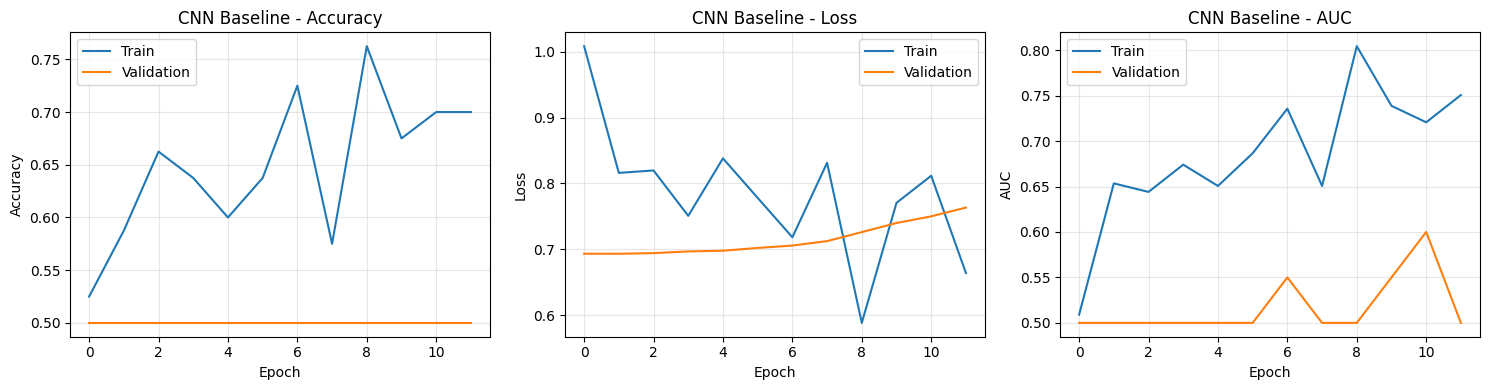

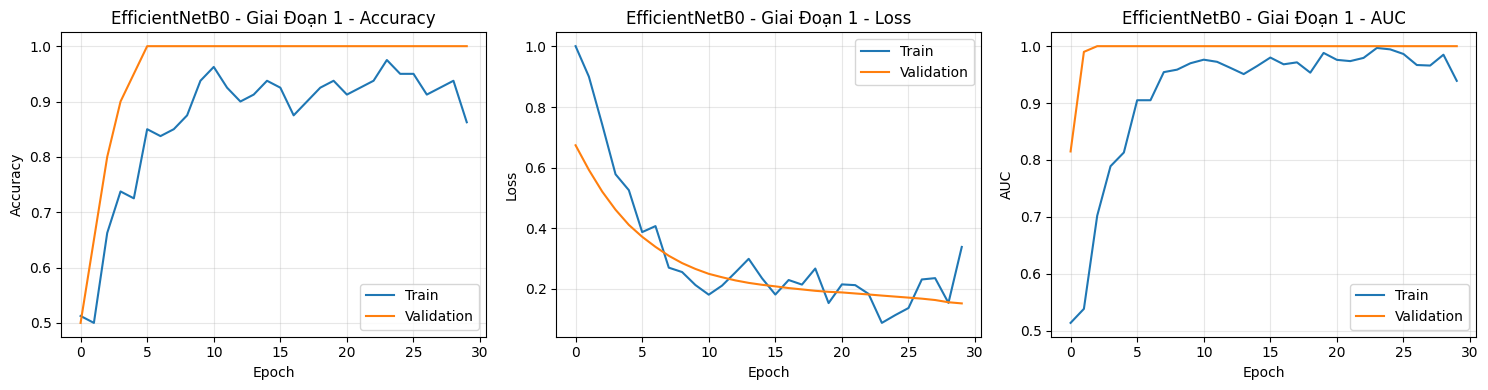

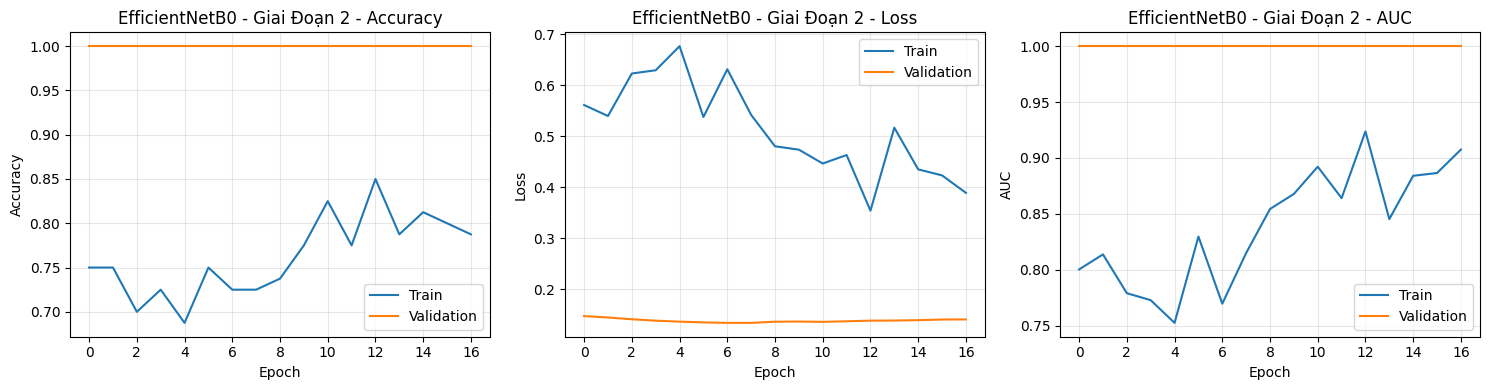

In [60]:
# Vẽ đồ thị Accuracy và Loss
def ve_do_thi_huan_luyen(lich_su, tieu_de):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Accuracy
    axes[0].plot(lich_su.history['accuracy'], label='Train')
    axes[0].plot(lich_su.history['val_accuracy'], label='Validation')
    axes[0].set_title(f'{tieu_de} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Loss
    axes[1].plot(lich_su.history['loss'], label='Train')
    axes[1].plot(lich_su.history['val_loss'], label='Validation')
    axes[1].set_title(f'{tieu_de} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # AUC
    axes[2].plot(lich_su.history['auc'], label='Train')
    axes[2].plot(lich_su.history['val_auc'], label='Validation')
    axes[2].set_title(f'{tieu_de} - AUC')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Vẽ các lịch sử
ve_do_thi_huan_luyen(lich_su_cnn, 'CNN Baseline')
ve_do_thi_huan_luyen(lich_su_eff_giai_doan_1, 'EfficientNetB0 - Giai Đoạn 1')
ve_do_thi_huan_luyen(lich_su_eff_giai_doan_2, 'EfficientNetB0 - Giai Đoạn 2')

Đánh giá: CNN Baseline



Loss: 0.6931
Accuracy: 0.5000
AUC: 0.5000

Báo cáo phân loại:
              precision    recall  f1-score   support

          HS     0.0000    0.0000    0.0000        10
          LS     0.5000    1.0000    0.6667        10

    accuracy                         0.5000        20
   macro avg     0.2500    0.5000    0.3333        20
weighted avg     0.2500    0.5000    0.3333        20



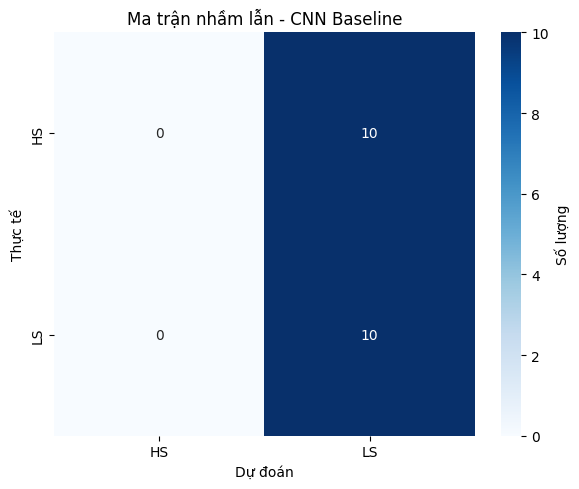

Đánh giá: EfficientNetB0

Loss: 0.1335
Accuracy: 1.0000
AUC: 1.0000

Báo cáo phân loại:
              precision    recall  f1-score   support

          HS     1.0000    1.0000    1.0000        10
          LS     1.0000    1.0000    1.0000        10

    accuracy                         1.0000        20
   macro avg     1.0000    1.0000    1.0000        20
weighted avg     1.0000    1.0000    1.0000        20



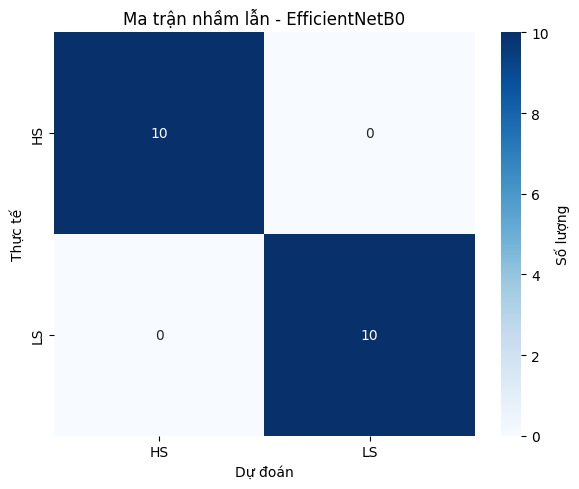

In [61]:
# Đánh giá models trên tập validation và in kết quả
def danh_gia_mo_hinh(mo_hinh, bo_sinh, ten_mo_hinh):

    print(f'Đánh giá: {ten_mo_hinh}')
    
    # Dự đoán
    bo_sinh.reset()
    y_du_doan_xac_suat = mo_hinh.predict(bo_sinh, verbose=0)
    y_du_doan = (y_du_doan_xac_suat > 0.5).astype(int).flatten()
    y_thuc = bo_sinh.classes
    
    # Metrics
    loss, do_chinh_xac, diem_auc = mo_hinh.evaluate(bo_sinh, verbose=0)
    print(f'\nLoss: {loss:.4f}')
    print(f'Accuracy: {do_chinh_xac:.4f}')
    print(f'AUC: {diem_auc:.4f}')
    
    # Classification report
    print('\nBáo cáo phân loại:')
    print(classification_report(y_thuc, y_du_doan, target_names=['HS', 'LS'], digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_thuc, y_du_doan)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['HS', 'LS'], yticklabels=['HS', 'LS'],
                cbar_kws={'label': 'Số lượng'})
    plt.title(f'Ma trận nhầm lẫn - {ten_mo_hinh}')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.tight_layout()
    plt.show()
    
    return y_thuc, y_du_doan, y_du_doan_xac_suat

# Đánh giá CNN
y_thuc_cnn, y_du_doan_cnn, y_xac_suat_cnn = danh_gia_mo_hinh(mo_hinh_cnn, bo_sinh_val, 'CNN Baseline')

# Đánh giá EfficientNet
y_thuc_eff, y_du_doan_eff, y_xac_suat_eff = danh_gia_mo_hinh(mo_hinh_efficientnet, bo_sinh_val_eff, 'EfficientNetB0')

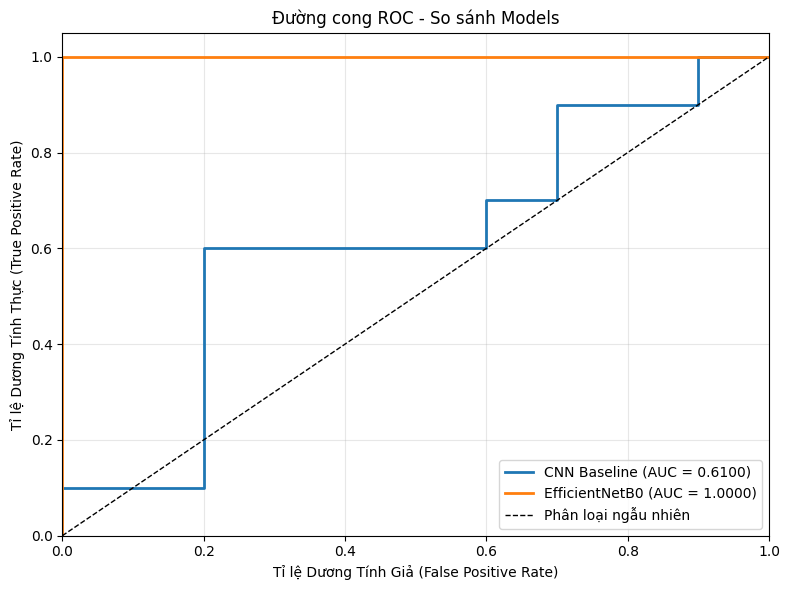

In [62]:
# So sánh ROC curves
from sklearn.metrics import roc_curve, auc

fpr_cnn, tpr_cnn, _ = roc_curve(y_thuc_cnn, y_xac_suat_cnn)
fpr_eff, tpr_eff, _ = roc_curve(y_thuc_eff, y_xac_suat_eff)

roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
roc_auc_eff = auc(fpr_eff, tpr_eff)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN Baseline (AUC = {roc_auc_cnn:.4f})', linewidth=2)
plt.plot(fpr_eff, tpr_eff, label=f'EfficientNetB0 (AUC = {roc_auc_eff:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Phân loại ngẫu nhiên', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tỉ lệ Dương Tính Giả (False Positive Rate)')
plt.ylabel('Tỉ lệ Dương Tính Thực (True Positive Rate)')
plt.title('Đường cong ROC - So sánh Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()